In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from extrapolator import *
import extrapolator
pd.set_option('display.precision', 18)
np.set_printoptions(precision=18)

In [17]:
be_3po = upload_basis('/home/trulyaldi/extrapolation/new-dataset/be_3po_test.csv')
be_3po_err = upload_error('/home/trulyaldi/extrapolation/new-dataset/be_3po_test.csv')
be_3po_init = be_3po[:-1]
be_3po_inf = be_3po.tail(1)

be_3se_01 = upload_basis('/home/trulyaldi/extrapolation/new-dataset/be_3se_01_test.csv')
be_3se_01_err = upload_error('/home/trulyaldi/extrapolation/new-dataset/be_3se_01_test.csv')
be_3se_01_init = be_3se_01[:-1]
be_3se_01_inf = be_3se_01.tail(1)

be_3se_02 = upload_basis('/home/trulyaldi/extrapolation/new-dataset/be_3se_02_test.csv')
be_3se_02_err = upload_error('/home/trulyaldi/extrapolation/new-dataset/be_3se_02_test.csv')
be_3se_02_init = be_3se_02[:-1]
be_3se_02_inf = be_3se_02.tail(1)



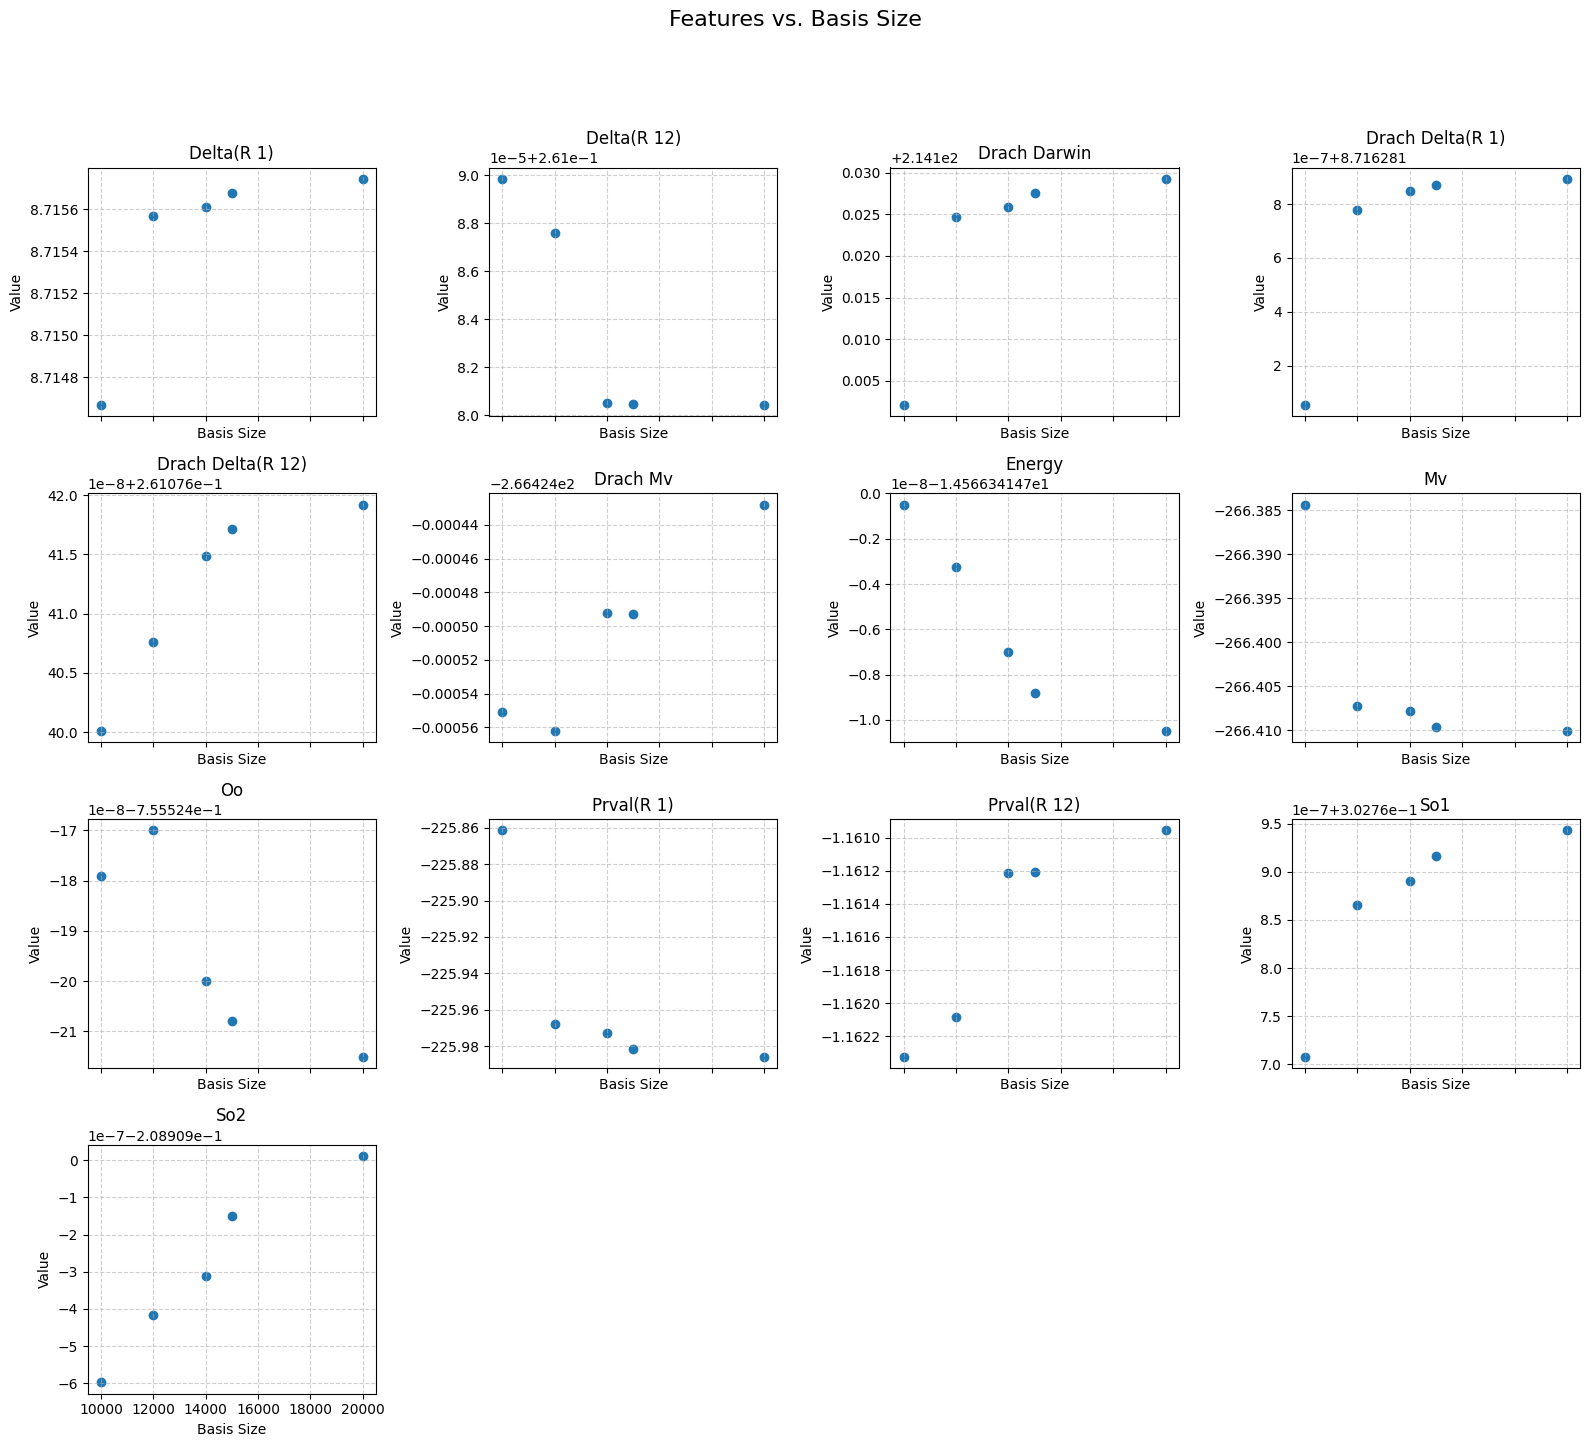

In [20]:
graph(be_3po)

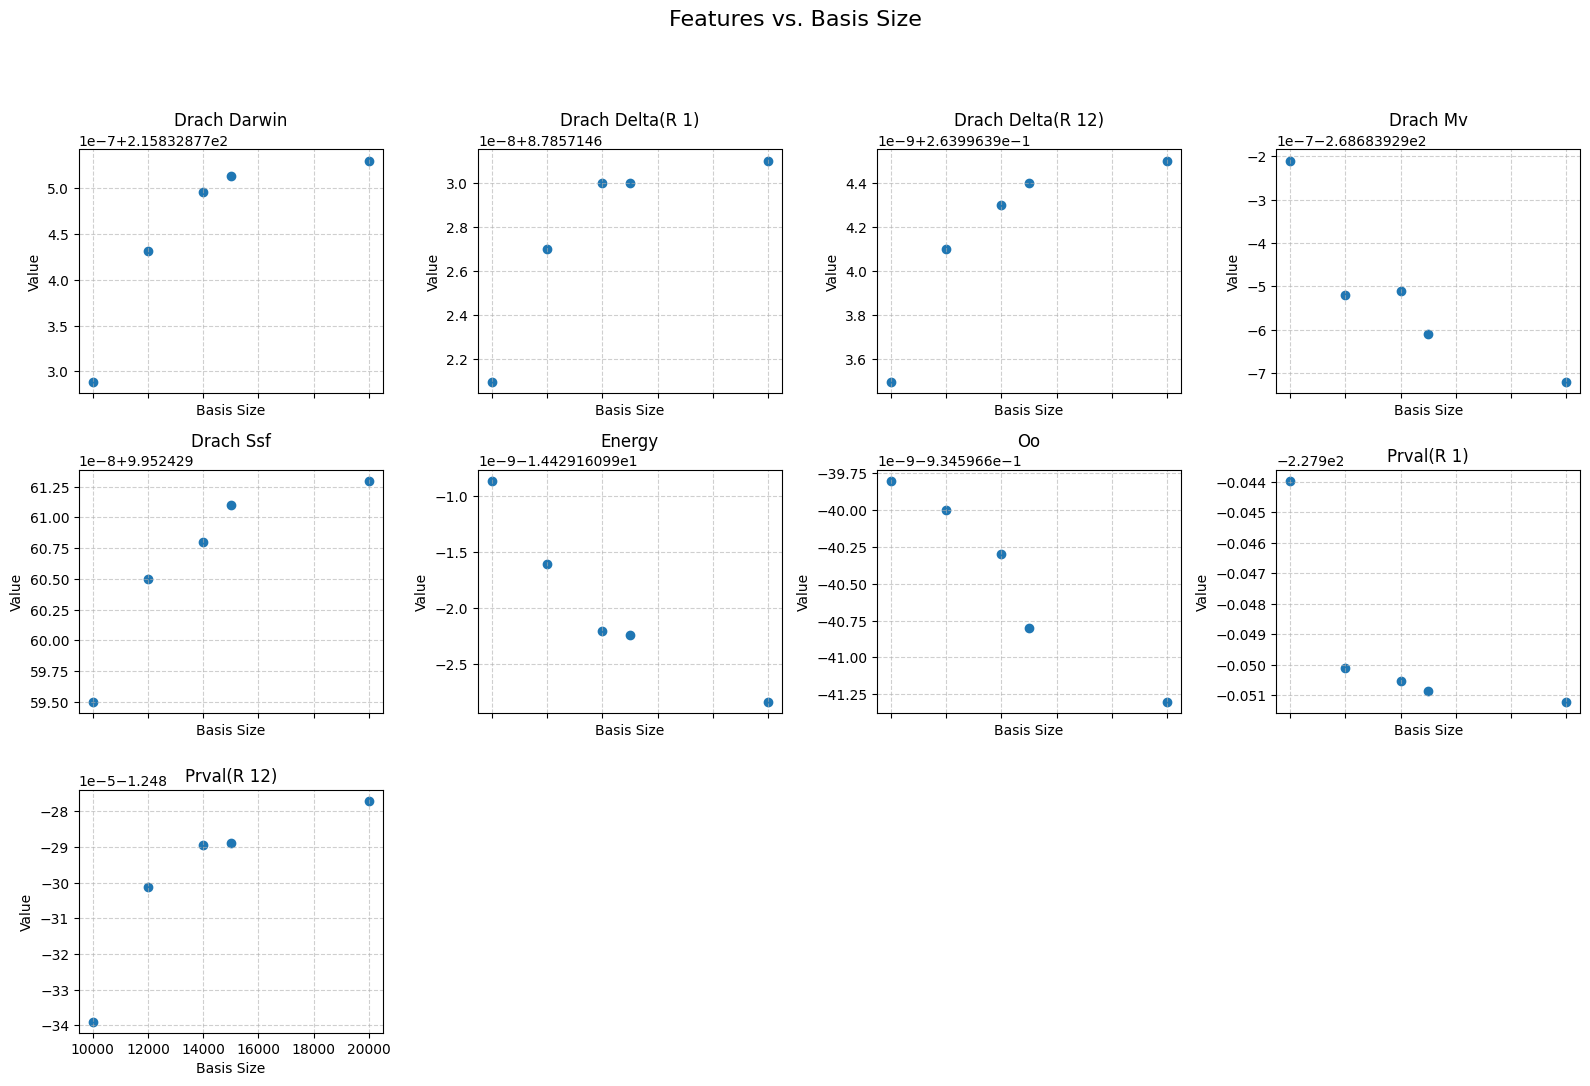

In [21]:
graph(be_3se_01)

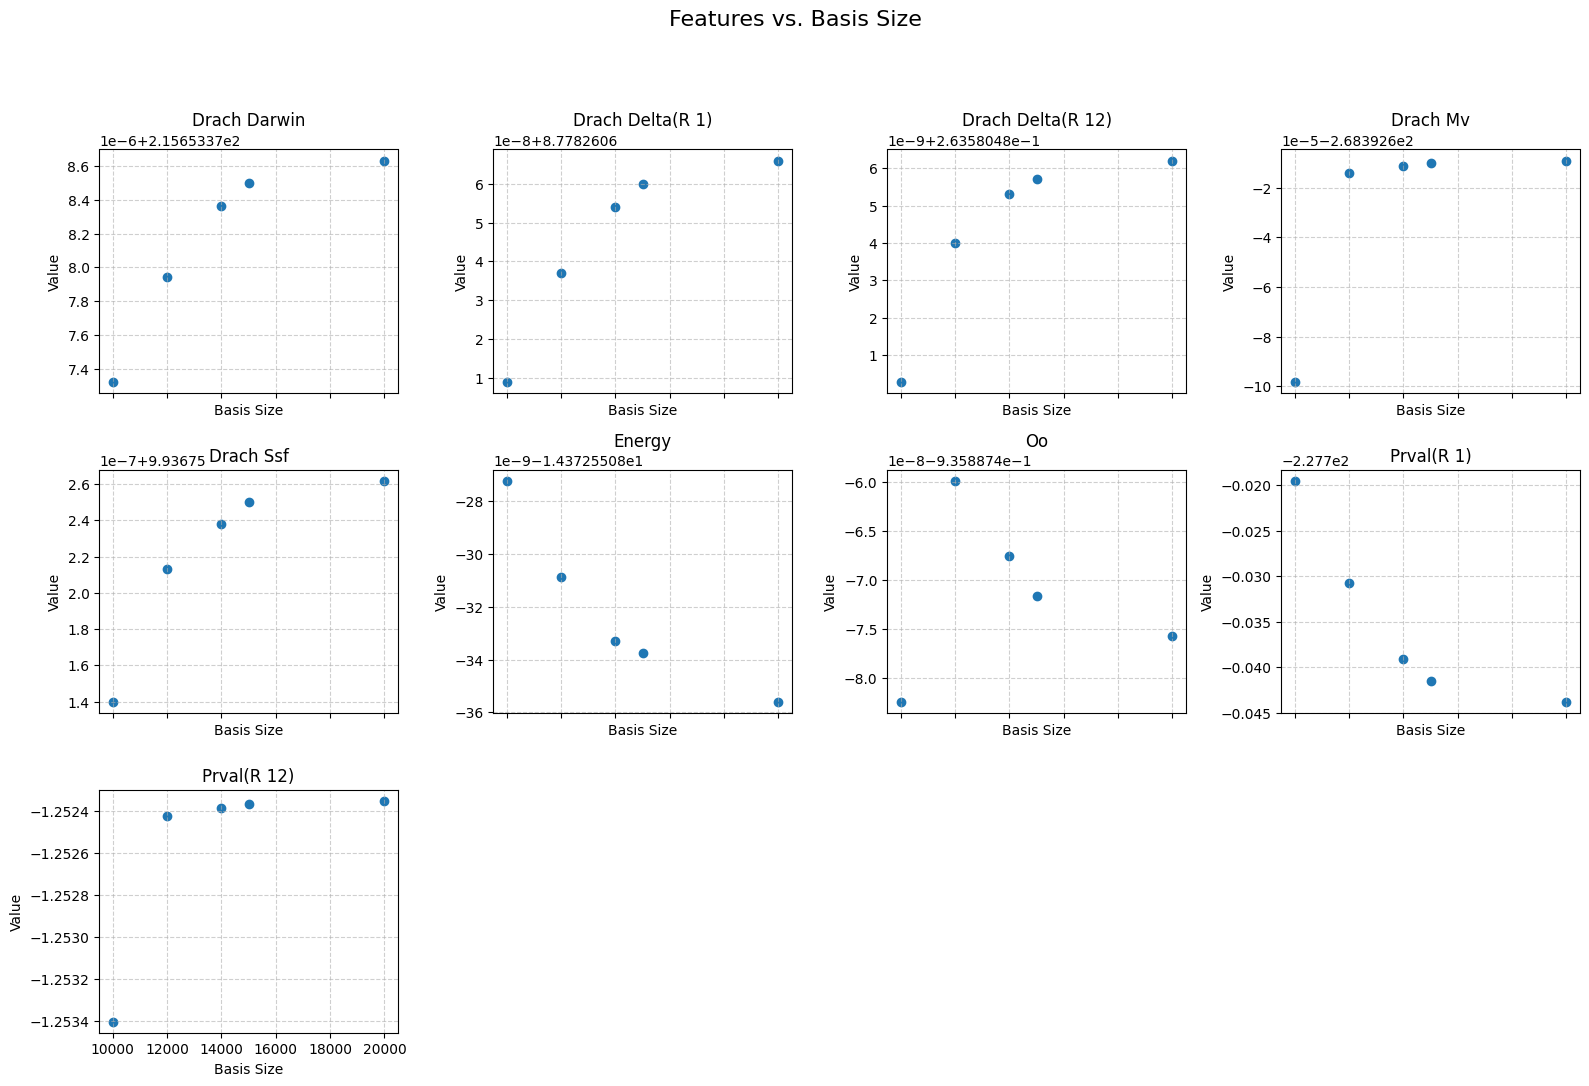

In [22]:
graph(be_3se_02)

In [41]:
be_3po

,basis size,Energy,MV,drach_MV,OO,SO1,SO2,delta(r_1),delta(r_12),drach_delta(r_1),drach_delta(r_12),prval(r_1),prval(r_12),drach_Darwin
0,10000,-14.566341470490000276,-266.384374999999977263,-266.424551000000008116,-0.755524179000000018,0.302760707999999990,-0.208909598000000002,8.714667920000000123,0.261089854000000010,8.716281052999999446,0.261076400099999995,-225.861432000000007747,-1.162322089999999974,214.102066000000007762
1,12000,-14.566341473250000504,-266.407287999999994099,-266.424561999999980344,-0.755524170000000050,0.302760866000000017,-0.208909416999999986,8.715565760000000495,0.261087612000000024,8.716281777000000730,0.261076407600000004,-225.967606999999986783,-1.162083860000000080,214.124673000000001366
2,14000,-14.566341476990000814,-266.407753000000013799,-266.424491999999986547,-0.755524199999999979,0.302760890000000005,-0.208909310999999986,8.715610079999999371,0.261080517999999984,8.716281846999999416,0.261076414899999998,-225.972520000000002938,-1.161212080000000091,214.125921000000005279
3,15000,-14.566341478800000075,-266.409592999999972562,-266.424492999999984022,-0.755524207999999975,0.302760915999999991,-0.208909149999999988,8.715677019999999331,0.261080474999999979,8.716281870999999626,0.261076417100000013,-225.981448000000000320,-1.161208629999999964,214.127603999999990947
4,20000,-14.566341480480000214,-266.410057999999992262,-266.424427999999977601,-0.755524214999999999,0.302760943000000005,-0.208908988999999989,8.715743959999999291,0.261080431999999973,8.716281893999999753,0.261076419200000021,-225.985752999999988333,-1.160956820000000000,214.129287000000005037


In [42]:
be_3po_err

,basis size,Energy,MV,drach_MV,OO,SO1,SO2,delta(r_1),delta(r_12),drach_delta(r_1),drach_delta(r_12),prval(r_1),prval(r_12),drach_Darwin
5,30000,0.000000001675999783,0.000465295281,0.00006465438651,0.000000007343776,0.00000002636368,0.000000160626702,0.00006694096232,0.0000000433012459,0.0000000233445298,0.000000002141673,0.00430493963,0.0002518028299,0.000001639497583


In [53]:

from extrapolator import unified_extrapolator

def extrapolate_be_3po(df_be_3po, df_errors, ref_basis_size=20000):
    """
    Extrapolate be_3po dataframe using unified_extrapolator for each expectation value.
    
    Uses basis sizes [10000, 12000, 14000, 15000] to extrapolate to infinity.
    Reference values come from basis size 20000 row in df_be_3po.
    Uncertainties come from df_errors.
    
    Parameters:
    -----------
    df_be_3po : DataFrame
        Contains basis sizes [10000, 12000, 14000, 15000, 20000] and expectation values
        Basis size 20000 row is used for reference values (NOT in fit)
        Must have 'basis size' column
    df_errors : DataFrame
        Contains reference uncertainties for each expectation value
        Each column (except 'basis size') has uncertainty values
    ref_basis_size : float
        The reference basis size value (20000) - used to identify reference row
    
    Returns:
    --------
    be_3po_df : DataFrame
        Extrapolated values in format matching reference_values dataframe
    """
    
    # Get list of expectation values (all columns except 'basis size')
    expectation_values = [col for col in df_be_3po.columns if col != 'basis size']
    
    # Find the reference row (basis size 20000)
    ref_row_mask = df_be_3po['basis size'] == ref_basis_size
    if not ref_row_mask.any():
        raise ValueError(f"Basis size {ref_basis_size} not found in df_be_3po")
    ref_row_idx = df_be_3po[ref_row_mask].index[0]
    
    # Get fitting data (exclude basis size 20000)
    df_fit = df_be_3po[~ref_row_mask].copy()
    
    if len(df_fit) == 0:
        raise ValueError("No data left after removing reference basis size")
    
    # Dictionary to store results
    results = {
        'system': [],
        'expectation_value': [],
        'ref_value': [],
        'uncertainty': [],
        'source': [],
        'exp_inf': [],
        'exp_sq_inf': [],
        'power_inf': [],
        'exp_unc': [],
        'exp_sq_unc': [],
        'power_unc': []
    }
    
    print("=" * 140)
    print(f"EXTRAPOLATING be_3po")
    print(f"Fit basis sizes: {df_fit['basis size'].tolist()}")
    print(f"Reference basis size: {ref_basis_size} (NOT used in fit)")
    print("=" * 140)
    print()
    
    # For each expectation value
    for exp_val in expectation_values:
        print(f"\nProcessing: {exp_val:<25}")
        print("-" * 140)
        
        # Get reference VALUE from basis size 20000 row
        ref_value = df_be_3po.loc[ref_row_idx, exp_val]
        
        # Get uncertainty from df_errors
        if exp_val in df_errors.columns:
            uncertainty = df_errors[exp_val].iloc[0]
        else:
            print(f"  ERROR: {exp_val} not found in df_errors, skipping...")
            continue
        
        try:
            # Create extrapolator instance with ONLY the fitting data (no basis size 20000)
            extrap = unified_extrapolator(df_fit)
            
            # Fit the column (this internally handles all 3 models)
            max_x = 1e10  # Large number for "infinity"
            extrap.fit_column(exp_val, max_x)
            
            # Extract results from the three models
            # The results dict contains: 'exponential', 'exponential_sq', 'power'
            
            # Exponential model
            exp_result = extrap.results['exponential']
            exp_inf = exp_result.params['C'].value
            exp_unc = extrap.uncertainties['exponential']
            
            # Exponential sqrt model
            exp_sq_result = extrap.results['exponential_sq']
            exp_sq_inf = exp_sq_result.params['C'].value
            exp_sq_unc = extrap.uncertainties['exponential_sq']
            
            # Power law model
            power_result = extrap.results['power']
            power_inf = power_result.params['C'].value
            power_unc = extrap.uncertainties['power']
            
            # Add to results
            results['system'].append('be_3po')
            results['expectation_value'].append(exp_val)
            results['ref_value'].append(ref_value)
            results['uncertainty'].append(uncertainty)
            results['source'].append('our_calc_20000')
            results['exp_inf'].append(exp_inf)
            results['exp_sq_inf'].append(exp_sq_inf)
            results['power_inf'].append(power_inf)
            results['exp_unc'].append(exp_unc)
            results['exp_sq_unc'].append(exp_sq_unc)
            results['power_unc'].append(power_unc)
            
            print(f"  ✓ Reference value (basis 20000): {ref_value:.15e}")
            print(f"  ✓ Uncertainty:                   {uncertainty:.15e}")
            print(f"  ✓ Exponential extrapolation:     {exp_inf:.15e} ± {exp_unc:.15e}")
            print(f"  ✓ Exponential √x extrapolation:  {exp_sq_inf:.15e} ± {exp_sq_unc:.15e}")
            print(f"  ✓ Power Law extrapolation:       {power_inf:.15e} ± {power_unc:.15e}")
            
        except Exception as e:
            print(f"  ERROR during fitting: {str(e)}")
            import traceback
            traceback.print_exc()
            continue
    
    print()
    print("=" * 140)
    
    # Create DataFrame
    be_3po_df = pd.DataFrame(results)
    
    print(f"✓ Extrapolation complete: {len(be_3po_df)} expectation values")
    print(f"✓ Successfully fitted columns: {be_3po_df['expectation_value'].tolist()}")
    print()
    
    return be_3po_df


In [55]:
be_3po_df = extrapolate_be_3po(be_3po, be_3po_err,ref_basis_size=20000)

EXTRAPOLATING be_3po
Fit basis sizes: [10000, 12000, 14000, 15000]
Reference basis size: 20000 (NOT used in fit)


Processing: Energy                   
--------------------------------------------------------------------------------------------------------------------------------------------

--- Fitting Exponential Model ---
  Initial guesses: C=-14.566341, A=0.000000, B=0.100000
  Model type: exp
  No known convergent value provided, using weight power n=1 for Exponential
Fitted parameters:
  C = -14.5663414763 ± 0.0000004452 (asymptote)
  A = 0.0000000059 ± 0.0000004498 (amplitude)
  B = 0.1000000000 ± 6.0270015957 (decay rate)
Parameter signs: C=negative, A=positive, B=positive
Fit quality: χ² = 1.066616e-16, RMSE = 5.163854e-09

--- Fitting Exponential SQ Model ---
  Initial guesses: C=-14.566341, A=0.000000, B=0.100000
  Model type: exp_sq
  No known convergent value provided, using weight power n=1 for Exponential SQ
Fitted parameters:
  C = -14.5663414763 ± 0.0000006607 (asymp

In [56]:
be_3po_df

,system,expectation_value,ref_value,uncertainty,source,exp_inf,exp_sq_inf,power_inf,exp_unc,exp_sq_unc,power_unc
0,be_3po,Energy,-14.566341480480000214,0.000000001675999783,our_calc_20000,-14.566341476346666539,-14.566341476346666539,-14.566341473655382899,0.000000445221937561,0.000000660719627024,0.000000287585684515
1,be_3po,MV,-266.410057999999992262,0.000465295281000000,our_calc_20000,-266.413252452425638239,-266.410885681447382467,-266.413633605175050434,0.009938747817591005,0.003622861813861770,0.010300703684608128
2,be_3po,drach_MV,-266.424427999999977601,0.000064654386510000,our_calc_20000,-266.424492508416335568,-266.424492504654722325,-266.424462430507674071,0.000000000000000000,0.000000000000000000,0.000192423127643483
3,be_3po,OO,-0.755524214999999999,0.000000007343776000,our_calc_20000,-0.755524197232192662,-0.755524204037268166,-0.755524229983843387,0.000000032048342127,0.000000000000000000,0.000000000000020580
4,be_3po,SO1,0.302760943000000005,0.000000026363680000,our_calc_20000,0.302760939637374604,0.302761014233108694,0.302760945289031191,0.000000050423515241,0.000000141652504268,0.000000053227992295
5,be_3po,SO2,-0.208908988999999989,0.000000160626702000,our_calc_20000,-0.208908688572606333,-0.208908698588915781,-0.208908593298847811,0.000001860677389975,0.000004639949580124,0.000003011104826755
6,be_3po,delta(r_1),8.715743959999999291,0.000066940962320000,our_calc_20000,8.715689913512376208,8.715746618627019160,8.715884052424216932,0.000059034484654641,0.000127217604955408,0.000483939279862664
7,be_3po,delta(r_12),0.261080431999999973,0.000000043301245900,our_calc_20000,0.261069571043115456,0.261069560478382701,0.261066545733179334,0.000017888503245337,0.000141166254204236,0.000060632657241963
8,be_3po,drach_delta(r_1),8.716281893999999753,0.000000023344529800,our_calc_20000,8.716281882490829247,8.716281924306819917,8.716282047676614297,0.000000014687388600,0.000000015108821148,0.000000369720785068
9,be_3po,drach_delta(r_12),0.261076419200000021,0.000000002141673000,our_calc_20000,0.261076415169719300,0.261076414647770649,0.261076413200000024,0.000000017023501714,0.000000015509465081,0.000003965004888222


In [57]:
def add_function_ranks(df):
    """
    Add 18-tier ranking system with normalized scores [0, 1].
    
    Score 18 → 1.0 (Best: min error, min uncertainty, includes reference)
    Score 1  → 0.0 (Worst: max error, max uncertainty, doesn't include reference)
    """
    
    # ===== Calculate errors =====
    df['w_exp'] = np.abs(df['exp_inf'] - df['ref_value'])
    df['w_exp_sq'] = np.abs(df['exp_sq_inf'] - df['ref_value'])
    df['w_power'] = np.abs(df['power_inf'] - df['ref_value'])
    
    # ===== Calculate encapsulation =====
    df['encap_exp'] = df['w_exp'] <= df['exp_unc']
    df['encap_exp_sq'] = df['w_exp_sq'] <= df['exp_sq_unc']
    df['encap_power'] = df['w_power'] <= df['power_unc']
    
    # ===== Define 18 ranking tiers =====
    tiers = [
        ('min', 'min', True, 18),
        ('min', 'min', False, 17),
        ('min', 'med', True, 16),
        ('min', 'med', False, 15),
        ('min', 'max', True, 14),
        ('min', 'max', False, 13),
        ('med', 'min', True, 12),
        ('med', 'min', False, 11),
        ('med', 'med', True, 10),
        ('med', 'med', False, 9),
        ('med', 'max', True, 8),
        ('med', 'max', False, 7),
        ('max', 'min', True, 6),
        ('max', 'min', False, 5),
        ('max', 'med', True, 4),
        ('max', 'med', False, 3),
        ('max', 'max', True, 2),
        ('max', 'max', False, 1),
    ]
    
    # ===== For each row, assign scores =====
    for idx, row in df.iterrows():
        errors = {
            'exp': row['w_exp'],
            'exp_sq': row['w_exp_sq'],
            'power': row['w_power']
        }
        
        uncertainties = {
            'exp': row['exp_unc'],
            'exp_sq': row['exp_sq_unc'],
            'power': row['power_unc']
        }
        
        encapsulations = {
            'exp': row['encap_exp'],
            'exp_sq': row['encap_exp_sq'],
            'power': row['encap_power']
        }
        
        # Categorize errors
        error_min = min(errors.values())
        error_max = max(errors.values())
        
        error_priority = {}
        for model in ['exp', 'exp_sq', 'power']:
            if errors[model] == error_min:
                error_priority[model] = 'min'
            elif errors[model] == error_max:
                error_priority[model] = 'max'
            else:
                error_priority[model] = 'med'
        
        # Categorize uncertainties
        unc_min = min(uncertainties.values())
        unc_max = max(uncertainties.values())
        
        unc_priority = {}
        for model in ['exp', 'exp_sq', 'power']:
            if uncertainties[model] == unc_min:
                unc_priority[model] = 'min'
            elif uncertainties[model] == unc_max:
                unc_priority[model] = 'max'
            else:
                unc_priority[model] = 'med'
        
        # Assign tier score to each model
        model_scores = {}
        for model in ['exp', 'exp_sq', 'power']:
            err_p = error_priority[model]
            unc_p = unc_priority[model]
            encap = encapsulations[model]
            
            for tier_err_p, tier_unc_p, tier_encap, tier_score in tiers:
                if err_p == tier_err_p and unc_p == tier_unc_p and encap == tier_encap:
                    model_scores[model] = tier_score
                    break
        
        # Store raw scores (1-18)
        df.at[idx, 'score_exp_raw'] = model_scores['exp']
        df.at[idx, 'score_exp_sq_raw'] = model_scores['exp_sq']
        df.at[idx, 'score_power_raw'] = model_scores['power']
        
        # Normalize to [0, 1]
        # Formula: (raw_score - 1) / 17
        df.at[idx, 'score_exp_norm'] = (model_scores['exp'] - 1) / 17
        df.at[idx, 'score_exp_sq_norm'] = (model_scores['exp_sq'] - 1) / 17
        df.at[idx, 'score_power_norm'] = (model_scores['power'] - 1) / 17
    
    return df


# Usage:
# df = add_function_ranks(df)

In [58]:
be_3po_ranked = add_function_ranks(be_3po_df)


In [60]:
columns_to_remove = ['exp_inf', 'exp_sq_inf', 'power_inf', 'exp_unc', 'exp_sq_unc',
       'power_unc', 'w_exp', 'w_exp_sq', 'w_power', 'encap_exp',
       'encap_exp_sq', 'encap_power', 'score_exp_raw', 'score_exp_sq_raw',
       'score_power_raw']
be_3po_ranked = be_3po_ranked.drop(columns=columns_to_remove)
be_3po_ranked

,system,expectation_value,ref_value,uncertainty,source,score_exp_norm,score_exp_sq_norm,score_power_norm
0,be_3po,Energy,-14.566341480480000214,0.000000001675999783,our_calc_20000,0.882352941176470562,0.764705882352941124,0.294117647058823539
1,be_3po,MV,-266.410057999999992262,0.000465295281000000,our_calc_20000,0.529411764705882359,1.000000000000000000,0.058823529411764705
2,be_3po,drach_MV,-266.424427999999977601,0.000064654386510000,our_calc_20000,0.235294117647058820,0.588235294117647078,0.764705882352941124
3,be_3po,OO,-0.755524214999999999,0.000000007343776000,our_calc_20000,0.058823529411764705,0.941176470588235281,0.470588235294117641
4,be_3po,SO1,0.302760943000000005,0.000000026363680000,our_calc_20000,0.647058823529411797,0.058823529411764705,0.882352941176470562
5,be_3po,SO2,-0.208908988999999989,0.000000160626702000,our_calc_20000,0.647058823529411797,0.764705882352941124,0.176470588235294129
6,be_3po,delta(r_1),8.715743959999999291,0.000066940962320000,our_calc_20000,0.647058823529411797,0.882352941176470562,0.058823529411764705
7,be_3po,delta(r_12),0.261080431999999973,0.000000043301245900,our_calc_20000,1.000000000000000000,0.411764705882352922,0.176470588235294129
8,be_3po,drach_delta(r_1),8.716281893999999753,0.000000023344529800,our_calc_20000,1.000000000000000000,0.470588235294117641,0.058823529411764705
9,be_3po,drach_delta(r_12),0.261076419200000021,0.000000002141673000,our_calc_20000,0.882352941176470562,0.647058823529411797,0.058823529411764705


In [61]:
print(be_3po_ranked['score_exp_norm'].values.sum())
print(be_3po_ranked['score_exp_sq_norm'].values.sum())
print(be_3po_ranked['score_power_norm'].values.sum())

9.176470588235293
8.352941176470589
3.294117647058823


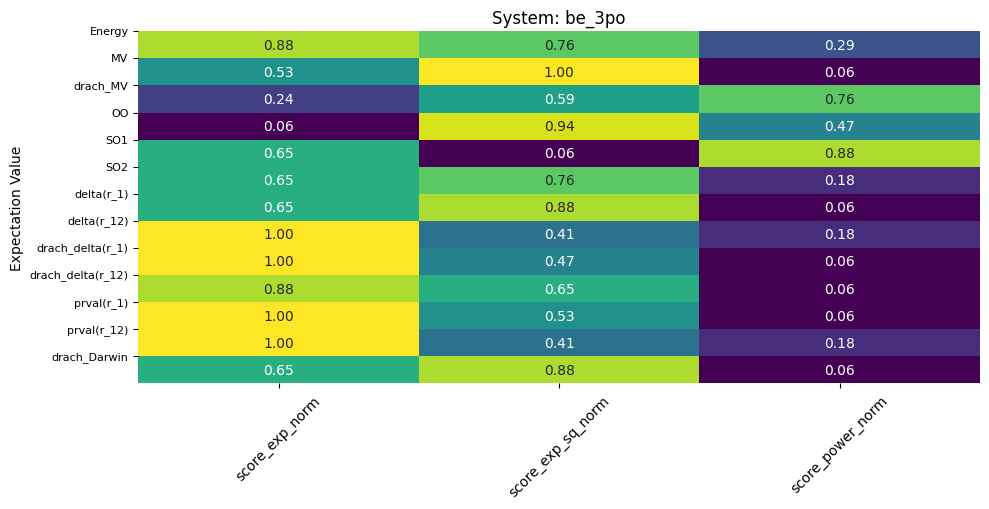

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt

# Melt to long format
df_long = be_3po_ranked.melt(
    id_vars=["system","expectation_value"],
    value_vars=['score_exp_norm','score_exp_sq_norm', 'score_power_norm'],
    var_name="method", value_name="rank"
)

# Clean method names
df_long["method"] = df_long["method"].str.replace("rank_", "")

# Full list of expectation values
all_expectations = [
    'Energy', 'MV', 'drach_MV', 'OO', 'SO1','SO2', 'delta(r_1)', 'delta(r_12)',
    'drach_delta(r_1)', 'drach_delta(r_12)', 'prval(r_1)', 'prval(r_12)', 'drach_Darwin'
]

# Plot one heatmap per system
systems = be_3po_ranked["system"].unique()
n_systems = len(systems)

fig, axes = plt.subplots(
    n_systems, 1, figsize=(10, max(4*n_systems, 0.4*len(all_expectations)))
)

# Make axes iterable even if n_systems=1
if n_systems == 1:
    axes = [axes]

for ax, system in zip(axes, systems):
    pivot = df_long[df_long["system"]==system].pivot(
        index="expectation_value", columns="method", values="rank"
    )
    pivot = pivot.reindex(all_expectations)  # ensure all rows

    sns.heatmap(
        pivot, cmap="viridis", annot=True, fmt=".2f", cbar=False, ax=ax
    )
    ax.set_title(f"System: {system}")
    ax.set_ylabel("Expectation Value")
    ax.set_xlabel("")

    # Force all labels to show
    ax.set_yticks(range(len(all_expectations)))
    ax.set_yticklabels(all_expectations, fontsize=8)

    ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()


In [65]:
be_3po_inf

,basis size,Energy,MV,drach_MV,OO,SO1,SO2,delta(r_1),delta(r_12),drach_delta(r_1),drach_delta(r_12),prval(r_1),prval(r_12),drach_Darwin
4,20000,-14.566341480480000214,-266.410057999999992262,-266.424427999999977601,-0.755524214999999999,0.302760943000000005,-0.208908988999999989,8.715743959999999291,0.261080431999999973,8.716281893999999753,0.261076419200000021,-225.985752999999988333,-1.16095682,214.129287000000005037


Available columns to analyze:
- Energy
- MV
- drach_MV
- OO
- SO1
- SO2
- delta(r_1)
- delta(r_12)
- drach_delta(r_1)
- drach_delta(r_12)
- prval(r_1)
- prval(r_12)
- drach_Darwin
------------------------------



--- Fitting Exponential Model ---
  Initial guesses: C=0.302761, A=-0.000000, B=0.100000
  Model type: exp
Optimizing Exponential weights using known value: 0.30276094
  Best weight power: 1 with distance 3.36e-09
Fitted parameters:
  C = 0.3027609396 ± 0.0000000504 (asymptote)
  A = -0.0000002150 ± 0.0000000666 (amplitude)
  B = 2.0964554609 ± 1.6901744711 (decay rate)
Parameter signs: C=positive, A=negative, B=positive
Fit quality: χ² = 3.028853e-16, RMSE = 8.701801e-09

--- Fitting Exponential SQ Model ---
  Initial guesses: C=0.302761, A=-0.000000, B=0.100000
  Model type: exp_sq
Optimizing Exponential SQ weights using known value: 0.30276094
  Best weight power: 1 with distance 7.12e-08
Fitted parameters:
  C = 0.3027610142 ± 0.0000001417 (asymptote)
  A = -0.0000003049 ± 0.0000001360 (amplitude)
  B = 1.0853805757 ± 0.8958800650 (decay rate)
Parameter signs: C=positive, A=negative, B=positive
Fit quality: χ² = 1.823023e-16, RMSE = 6.750968e-09

--- Fitting Power Law Model ---
Op

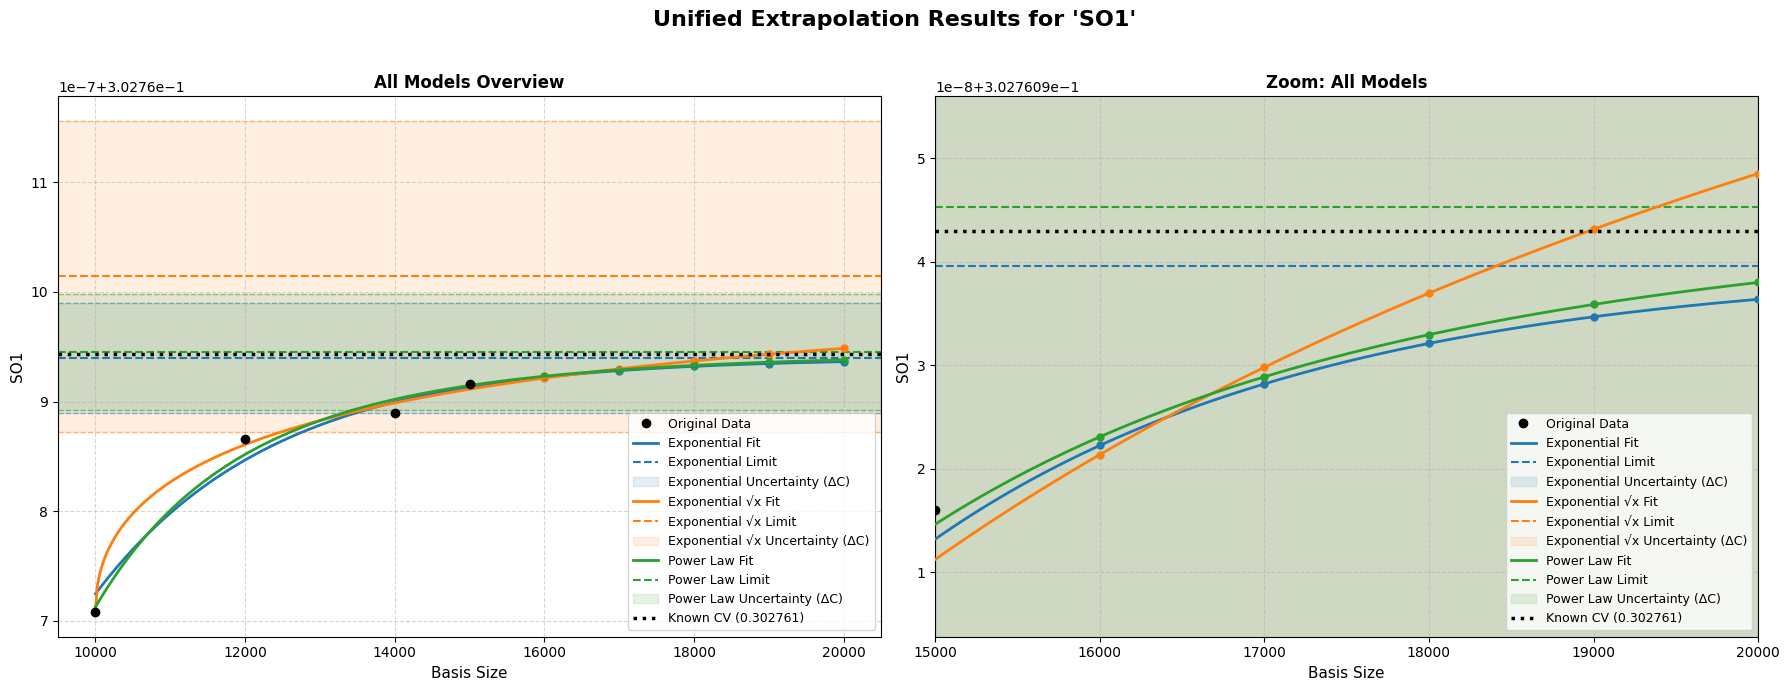

In [69]:
extrapolator.unified_extrapolator(be_3po_init).fit()